<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5B0806new%5D_machine_learning_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CNN_LSTM (20개 과거 → 5개 미래)

📊 업무시간 평균 CPU 사용률: 81.82%
📊 비업무시간 평균 CPU 사용률: 45.74%
✅ 조건 1 만족 여부 (둘 중 더 큰 값 기준 ≥ 80%): True (81.82%)


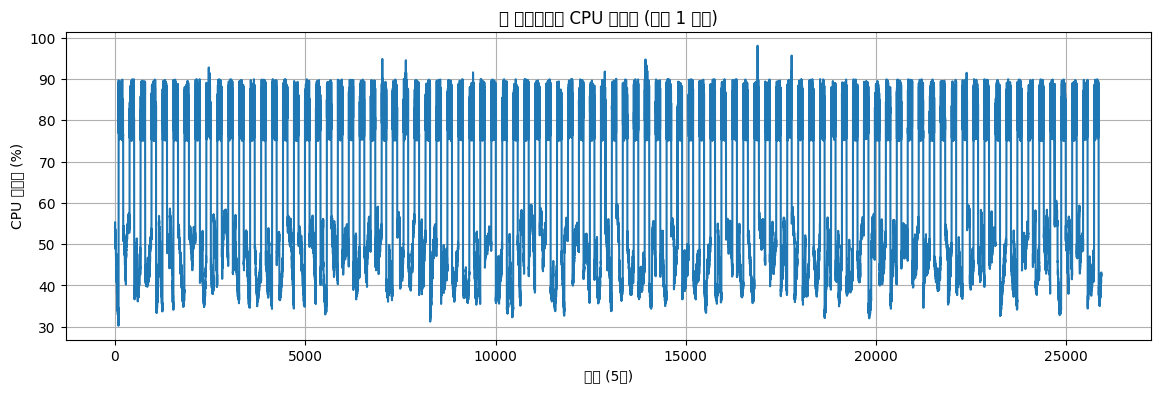

In [86]:
import numpy as np
from scipy.signal import sawtooth
import matplotlib.pyplot as plt

np.random.seed(42)
days = 90
points_per_day = 24 * 12
total_points = days * points_per_day

# 시간축
time = np.linspace(0, 1, total_points)

# 🌀 mix_wave를 날짜별로 다른 파형으로 생성 (불규칙성 강화)
mix_wave = np.zeros(total_points)
for d in range(days):
    offset = np.random.uniform(0, 2*np.pi)
    amp = np.random.uniform(0.8, 1.2)
    freq = np.random.uniform(0.8, 1.3)
    start = d * points_per_day
    end = (d+1) * points_per_day
    t = np.linspace(0, 2*np.pi, points_per_day)
    wave = (
        amp * np.sin(freq * t + offset) +
        0.3 * sawtooth(freq * t + offset) +
        0.2 * (2 * np.abs((t / np.pi) % 2 - 1) - 1)
    )
    wave += np.random.normal(0, 0.1, points_per_day)
    mix_wave[start:end] = wave

# 🎯 trend도 날마다 다르게 생성
trend = np.zeros(total_points)
for d in range(days):
    start = d * points_per_day
    end = (d + 1) * points_per_day
    slope = np.random.uniform(-5, 5)
    curve = np.random.uniform(0, 3)
    t = np.linspace(0, 1, points_per_day)
    trend[start:end] = slope * t + curve * (t - 0.5)**2

# 업무시간 마스크
work_hours = np.zeros(total_points)
for d in range(days):
    start_idx = d * points_per_day + 8 * 12
    end_idx = d * points_per_day + 18 * 12
    work_hours[start_idx:end_idx] = 1.0

# 📈 업무시간 부스팅도 날짜별로 랜덤한 범위에서 다르게 적용
boost_add = np.zeros(total_points)
for d in range(days):
    boost_level = np.random.uniform(20, 30)
    start_idx = d * points_per_day + 8 * 12
    end_idx = d * points_per_day + 18 * 12
    boost_add[start_idx:end_idx] = boost_level + np.random.normal(0, 5, end_idx - start_idx)

# ✅ 최종 CPU 사용률: 더 불규칙하게 구성
cpu = 45 + 10 * mix_wave + trend + boost_add

# ✅ 업무시간 하한선 보정
cpu = np.where((work_hours == 1) & (cpu < 75), np.random.uniform(75, 90, size=total_points), cpu)

# ✅ 전체 하한선 보정 (자연스러움 유지)
cpu = np.where(cpu < 30, 30 + (30 - cpu) * 0.3, cpu)

# ✅ 평균 계산
work_cpu = cpu[work_hours == 1.0]
nowork_cpu = cpu[work_hours == 0.0]
avg_work_cpu = np.mean(work_cpu)
avg_nowork_cpu = np.mean(nowork_cpu)
avg_cpu = max(avg_work_cpu, avg_nowork_cpu)
condition1 = avg_cpu >= 80

# ✅ 결과 출력
print(f"📊 업무시간 평균 CPU 사용률: {avg_work_cpu:.2f}%")
print(f"📊 비업무시간 평균 CPU 사용률: {avg_nowork_cpu:.2f}%")
print(f"✅ 조건 1 만족 여부 (둘 중 더 큰 값 기준 ≥ 80%): {condition1} ({avg_cpu:.2f}%)")

# ✅ 시각화 (5일만)
plt.figure(figsize=(14, 4))
plt.plot(cpu)
plt.title("📈 자연스러운 CPU 사용률 (조건 1 만족)")
plt.xlabel("시간 (5일)")
plt.ylabel("CPU 사용률 (%)")
plt.grid(True)
plt.show()


In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # 데이터 생성
# np.random.seed(42)
# days = 90
# points_per_day = 24 * 12

# # 복잡한 데이터
# # 1. 데이터 생성
# np.random.seed(42)
# total_points = days * points_per_day
# theta = np.linspace(0, 30 * np.pi, total_points)

# # 복합 파형 구성
# mix_wave = (
#     0.6 * np.sin(theta) +
#     0.3 * sawtooth(theta * 0.7) +
#     0.2 * (2 * np.abs((theta / np.pi) % 2 - 1) - 1) +
#     np.random.normal(0, 0.1, total_points)
# )

# mix_wave = np.where(mix_wave < 0, mix_wave * 1.8, mix_wave * 0.8)

# # ✅ 비선형 트렌드 수정
# # 앞부분 감소 → 중간 유지 → 끝부분 증가 형태로 설계
# # 구간별로 조합
# x = np.linspace(0, 1, total_points)
# trend = np.piecewise(x,
#     [x < 0.3, (x >= 0.3) & (x < 0.7), x >= 0.7],
#     [
#         lambda x: -10 * x,               # 앞부분 감소
#         lambda x: -3,                    # 중간 유지
#         lambda x: 20 * (x - 0.7)**1.5    # 끝부분 우상향 (가속 곡선)
#     ]
# )

# # 3. 업무시간 부스팅
# # 업무시간: 08:00 ~ 18:00 (10시간) → 10 * 12 = 120 step/day
# work_hours = np.zeros(total_points)

# for d in range(days):
#     start_idx = d * points_per_day + 8 * 12     # 08:00
#     end_idx = d * points_per_day + 18 * 12      # 18:00
#     work_hours[start_idx:end_idx] = 1.0         # 업무시간 표시

# # 사용률 부스팅: 업무시간에는 +30~50% 정도 올려줌
# boost = work_hours * np.random.uniform(0.5, 0.6, size=total_points)

# # 4. 최종 CPU 사용률 계산
# cpu = 60 + 30 * mix_wave + trend + 10 * boost  # boost를 퍼센트로 보정


# # 단순한 데이터
# # total_points = days * points_per_day
# # cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)


time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

scaler = MinMaxScaler()
cpu_scaled =pd.DataFrame( scaler.fit_transform(df[['cpu']]))

past_steps = 20
future_steps = 5

# ✅ 데이터 분할 (80:10:10)
n_total = len(cpu_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

cpu_train = cpu_scaled.iloc[:n_train]
cpu_val   = cpu_scaled.iloc[n_train:n_train + n_val]
cpu_test  = cpu_scaled.iloc[n_train + n_val:]

# ✅ 시퀀스 생성 함수
def create_sequences(data, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data.iloc[i:i+past_steps].values)
        y.append(data.iloc[i+past_steps:i+past_steps+future_steps].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(cpu_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(cpu_val, past_steps, future_steps)
X_test,  y_test  = create_sequences(cpu_test, past_steps, future_steps)

# ✅ 모델 정의 및 학습 (validation 포함)
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train.reshape((y_train.shape[0], -1)),
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val.reshape((y_val.shape[0], -1))),
    verbose=1
)

# ✅ 테스트 예측 및 성능 평가
pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1295/1295 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0284 - val_loss: 0.0105
Epoch 2/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 3/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 4/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 5/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 6/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 7/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 8/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 9/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 10/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 11/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 12/20
1295/1295 ━━━━━━━━━━

CNN-LSTM
MAE : 3.2055449506810705
RMSE: 6.169528611730047
R2: 0.887268676470843


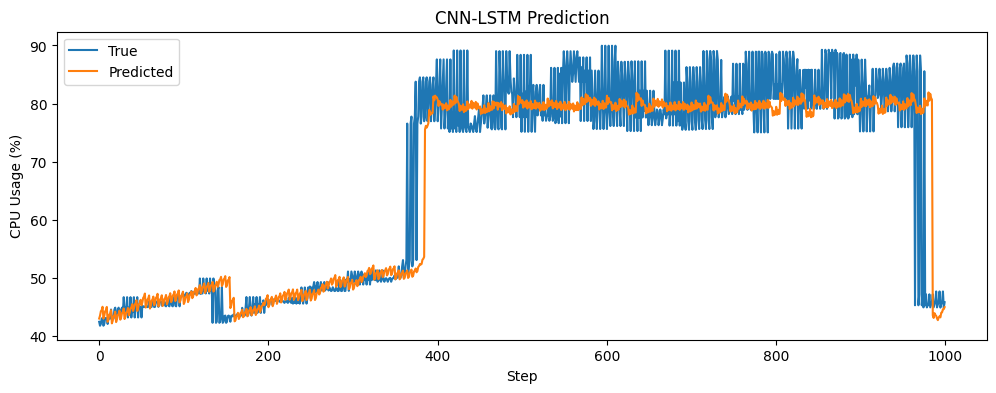

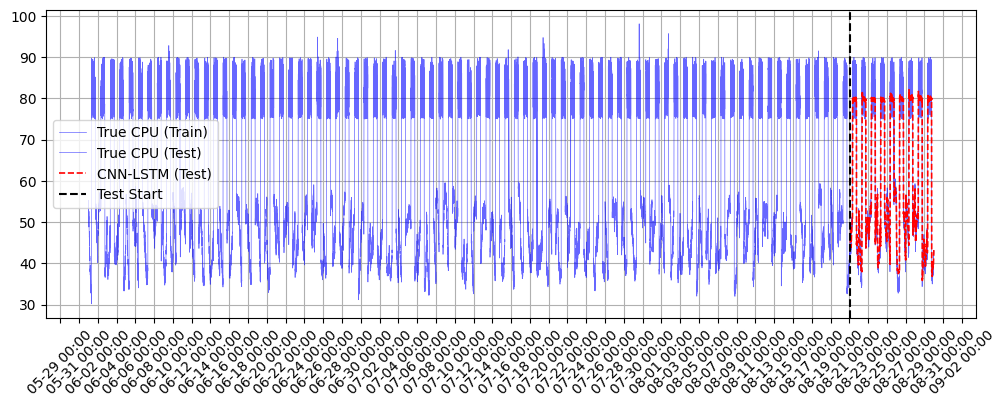

In [91]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지
val_series = df['cpu'][train_end:val_end] # validation data
test_series_true= df['cpu'][test_start_idx:]

# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

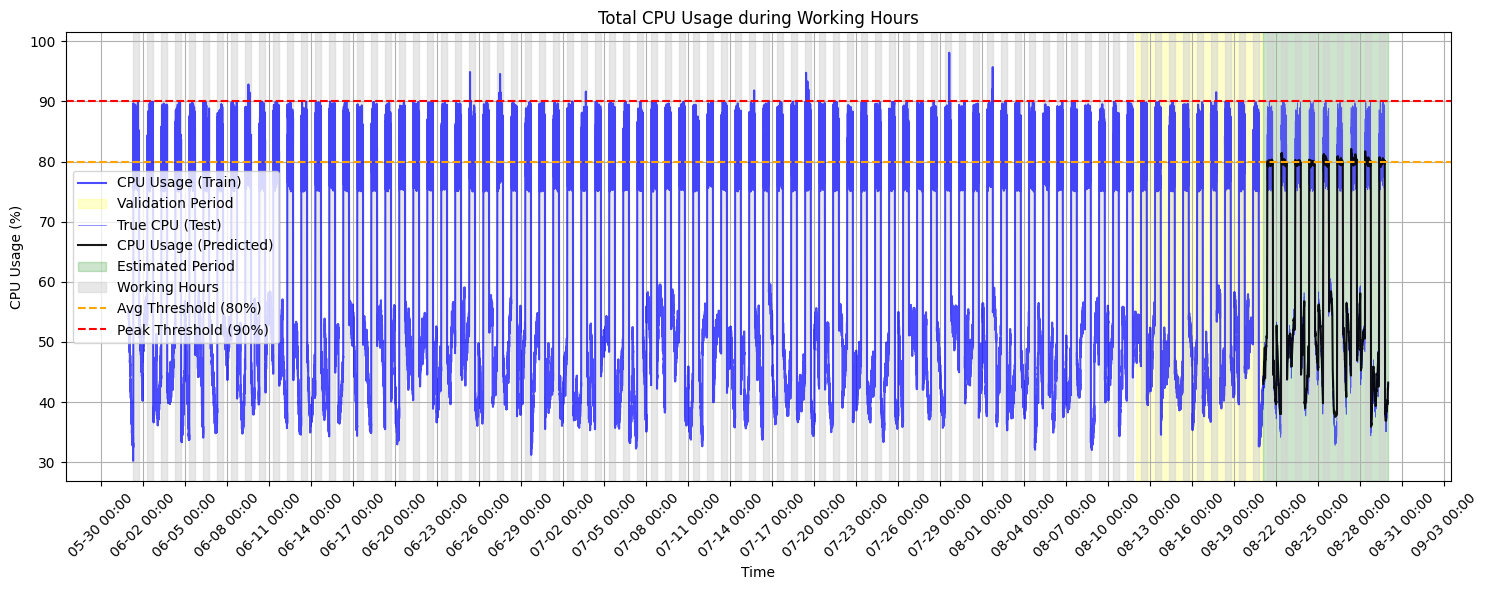

In [95]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['cpu'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "cpu_pred"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 CPU 사용률 ≥ 80% (업무시간, 비업무시간 분리)
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['cpu'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="CPU Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# # 업그레이드 신호 표시
# if len(upgrade_times) > 0:
#     ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total CPU Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장

# 평균 사용률 저장
cpu_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
cpu_avg_df.to_csv("cpu_avg_usage_CNN-LSTM3.csv", index=False)

import json
with open("cpu_accuracy_metrics_CNN-LSTM3.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_CNN-LSTM3.csv") # 전체 cpu
test_series_pred.to_csv("cpu_usage_predicted_only_CNN-LSTM3.csv") # 예측 구간 cpu
work_time.to_csv("cpu_usage_working_hours_CNN-LSTM3.csv") # 업무시간 cpu
daily_peak.to_csv("cpu_peak_flag_per_day_CNN-LSTM3.csv") # peak 발생 여부

with open("upgrade_decision_CNN-LSTM3.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("cpu_plot_CNN-LSTM3.png")

In [53]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.5 MB/s eta 0:00:00


## 기준 따라서 증설 시점 정하기

average CPU :  59.94489


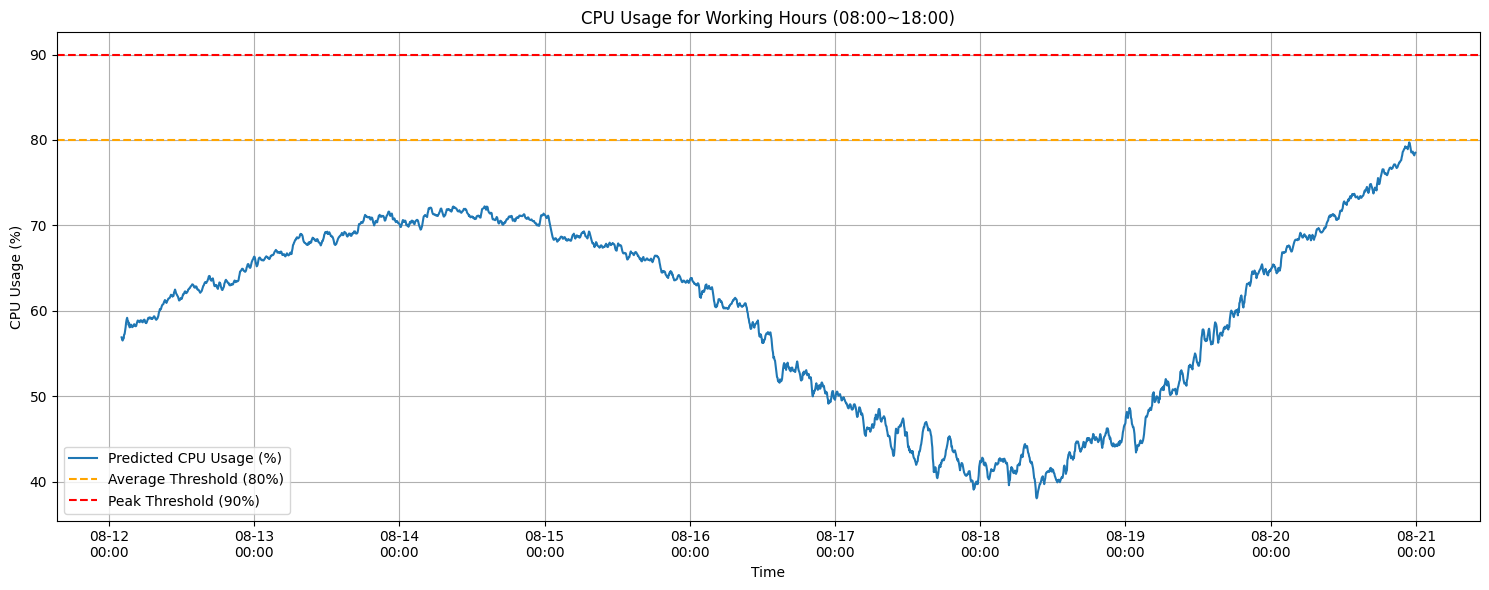

✅ Condition 1 (Avg CPU during working hours ≥ 80%): False
✅ Condition 2 (≥5 days with peak > 90% during working hours): False
🔍 Final Upgrade Decision: 🟩 No Upgrade Required


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 업무시간 필터링
test_time_index = df.index[split_point + past_steps + future_steps : split_point + past_steps + future_steps + len(pred_inv)]
time_series = pd.Series(pred_inv.mean(axis=1), index=test_time_index)
work_time = time_series.between_time("08:00", "18:00")

# 조건 1: 전체 업무시간 평균이 80% 이상 ---
avg_threshold = 80
condition1_flag = work_time.mean() >= avg_threshold
print("average CPU : ", work_time.mean() )

# 조건 2: 업무시간 내 피크가 매일 1회 이상 발생한 날이 80% 이상 ---
peak_threshold = 90
work_peak_flags = pd.Series((pred_inv > peak_threshold).any(axis=1), index=test_time_index).between_time("08:00", "18:00")

# 피크가 발생했는지 여부
daily_peak = work_peak_flags.groupby(work_peak_flags.index.date).any()

# 전체 일 수 중 피크가 발생한 비율이 80% 이상인지
total_days = len(daily_peak)
peak_days = daily_peak.sum()
condition2_flag = (peak_days / total_days) >= 0.8

# 조건1,2 교집합으로 판단
upgrade_flag = condition1_flag or condition2_flag

# 증설 타이밍 시각화용 표시
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    peak_days = daily_peak_count[daily_peak_count >= 1].index[:5]  # 처음 5일만 표시
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_days.astype(str))].index
else:
    upgrade_times = []

plt.figure(figsize=(15, 6))
plt.plot(time_series.index, time_series.values, label="Predicted CPU Usage (%)")
plt.axhline(avg_threshold, color='orange', linestyle='--', label="Average Threshold (80%)")
plt.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")
if len(upgrade_times) > 0:
    plt.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5)
plt.title("CPU Usage for Working Hours (08:00~18:00)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.tight_layout()
plt.show()

# 결과 출력
print(f"✅ Condition 1 (Avg CPU during working hours ≥ 80%): {condition1_flag}")
print(f"✅ Condition 2 (≥5 days with peak > 90% during working hours): {condition2_flag}")
print(f"🔍 Final Upgrade Decision: {'🟥 Upgrade Needed' if upgrade_flag else '🟩 No Upgrade Required'}")


🚨 Upgrade Timing Detected: 2025-06-15 08:00:00


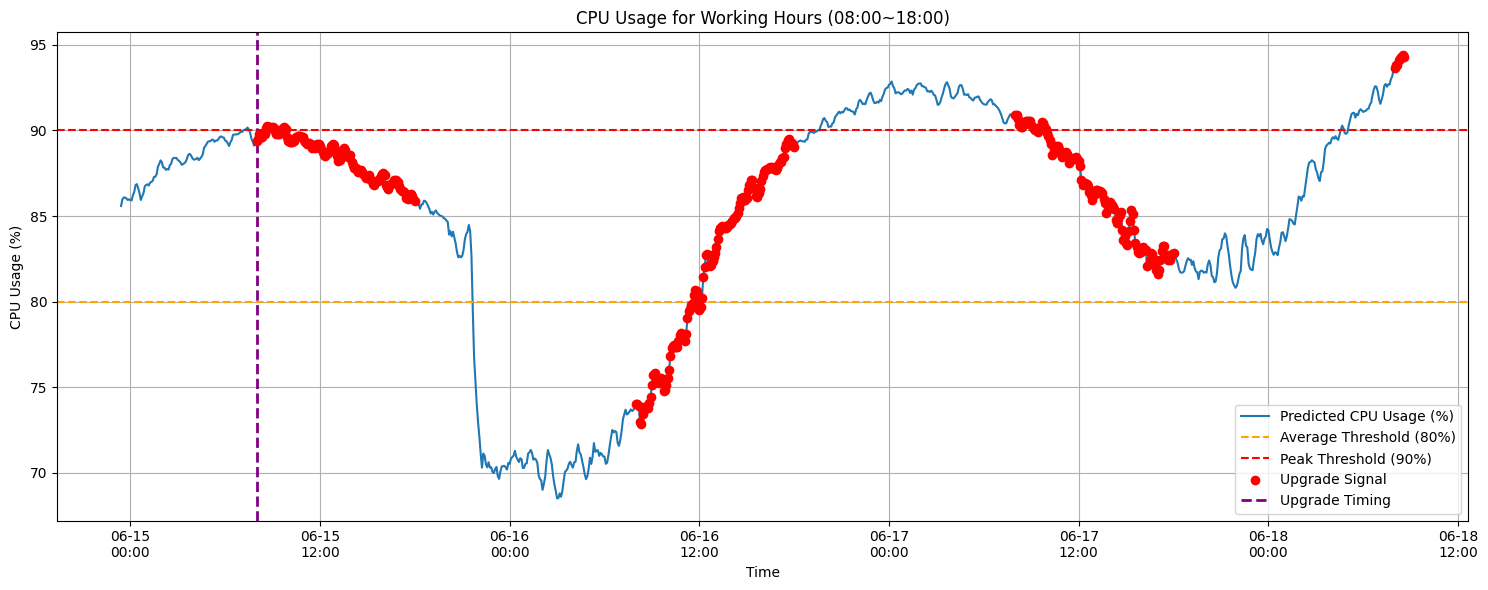

In [ ]:
# --- ✅ 증설 시점 판단 (처음 조건 만족한 시점 하나만 추출) ---
if len(upgrade_times) > 0:
    upgrade_time_final = upgrade_times[0]  # 첫 번째 발생 시점
    print(f"🚨 Upgrade Timing Detected: {upgrade_time_final}")
else:
    upgrade_time_final = None
    print("✅ No upgrade timing detected.")

# 시각화 (기존 코드 유지)
plt.figure(figsize=(15, 6))
plt.plot(time_series.index, time_series.values, label="Predicted CPU Usage (%)")
plt.axhline(avg_threshold, color='orange', linestyle='--', label="Average Threshold (80%)")
plt.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")
if len(upgrade_times) > 0:
    plt.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5)

# ✅ 첫 증설 시점을 선으로 시각화
if upgrade_time_final:
    plt.axvline(x=upgrade_time_final, color='purple', linestyle='--', linewidth=2, label='Upgrade Timing')

plt.title("CPU Usage for Working Hours (08:00~18:00)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.tight_layout()
plt.show()


## 2. 단순 CNN

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from scipy.signal import sawtooth


# 복잡한 데이터
# 1. 데이터 생성
# np.random.seed(42)
# days = 90
# points_per_day = 24 * 12
# total_points = days * points_per_day
# theta = np.linspace(0, 30 * np.pi, total_points)

# # 복합 파형 구성
# mix_wave = (
#     0.6 * np.sin(theta) +
#     0.3 * sawtooth(theta * 0.7) +
#     0.2 * (2 * np.abs((theta / np.pi) % 2 - 1) - 1) +
#     np.random.normal(0, 0.1, total_points)
# )

# mix_wave = np.where(mix_wave < 0, mix_wave * 1.8, mix_wave * 0.8)

# # ✅ 비선형 트렌드 수정
# # 앞부분 감소 → 중간 유지 → 끝부분 증가 형태로 설계
# # 구간별로 조합
# x = np.linspace(0, 1, total_points)
# trend = np.piecewise(x,
#     [x < 0.3, (x >= 0.3) & (x < 0.7), x >= 0.7],
#     [
#         lambda x: -10 * x,               # 앞부분 감소
#         lambda x: -3,                    # 중간 유지
#         lambda x: 20 * (x - 0.7)**1.5    # 끝부분 우상향 (가속 곡선)
#     ]
# )

# # 최종 CPU 시계열
# cpu = 60 + 40 * mix_wave + trend

# time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
# df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# scaler = MinMaxScaler()
# cpu_scaled =pd.DataFrame( scaler.fit_transform(df[['cpu']]))

# past_steps = 20
# future_steps = 5

# # ✅ 데이터 분할 (80:10:10)
# n_total = len(cpu_scaled)
# n_train = int(n_total * 0.8)
# n_val   = int(n_total * 0.1)

# cpu_train = cpu_scaled.iloc[:n_train]
# cpu_val   = cpu_scaled.iloc[n_train:n_train + n_val]
# cpu_test  = cpu_scaled.iloc[n_train + n_val:]

# # 정규화는 train만 fit
# split_point = int(len(cpu_scaled) * 0.8)
# df_train = cpu_scaled.iloc[:split_point]
# df_test = cpu_scaled.iloc[split_point:]


# # 시퀀스 생성
# def create_sequences(dataset, past_steps=20, future_steps=5):
#     X, y = [], []
#     for i in range(len(dataset) - past_steps - future_steps):
#         X.append(dataset[i:i+past_steps])
#         y.append(dataset[i+past_steps:i+past_steps+future_steps])
#     return np.array(X), np.array(y)

# past_steps = 20
# future_steps = 5

# X_train, y_train = create_sequences(cpu_train, past_steps, future_steps)
# X_val,   y_val   = create_sequences(cpu_val, past_steps, future_steps)
# X_test,  y_test  = create_sequences(cpu_test, past_steps, future_steps)


# CNN-only 모델
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# reshape for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train_cnn, y_train, epochs=20, batch_size=16, verbose=1)
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0224
Epoch 2/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0091
Epoch 3/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0088
Epoch 4/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0089
Epoch 5/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0088
Epoch 6/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0087
Epoch 7/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0084
Epoch 8/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0087
Epoch 9/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084
Epoch 10/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0083
Epoch 11/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0087
Epoch 12/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0089
Epoch 13/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0084
Epoch 14/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0088
Epoch 15/20
1295/1295 ━━━━━━━━━━━━━━━━━━

CNN
MAE : 3.3277840499936486
RMSE: 6.277163294429814
R²  : 0.8833008803879604


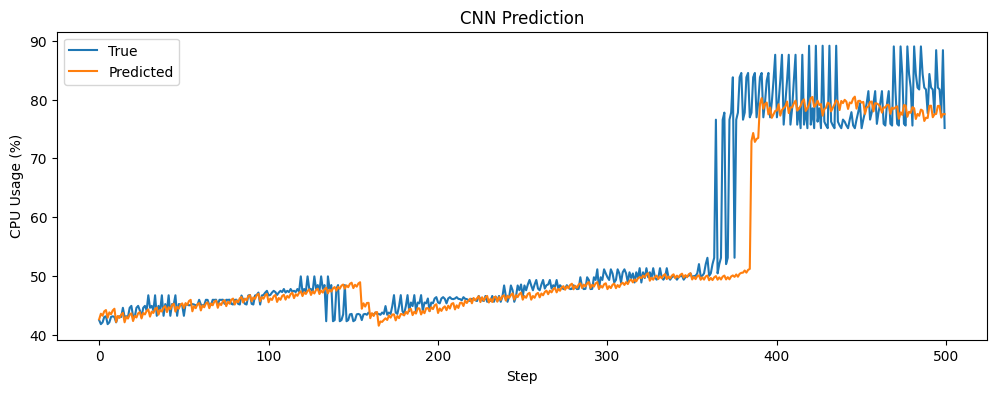

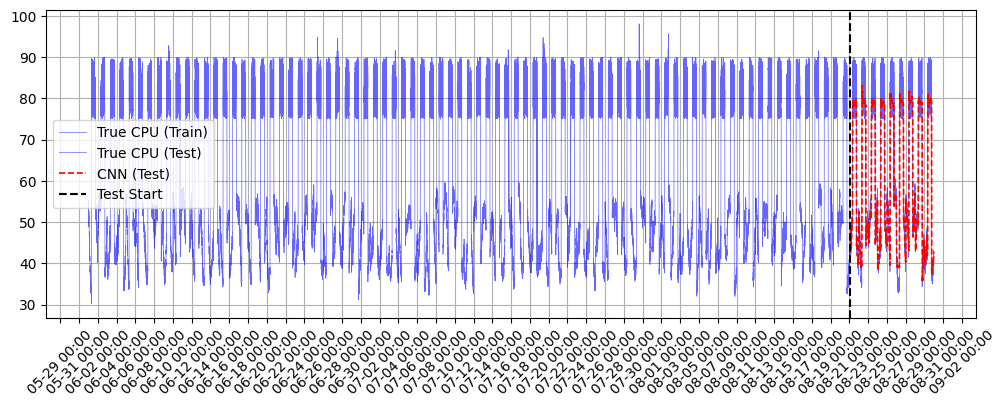

In [97]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지
val_series = df['cpu'][train_end:val_end] # validation data
test_series_true= df['cpu'][test_start_idx:]

# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

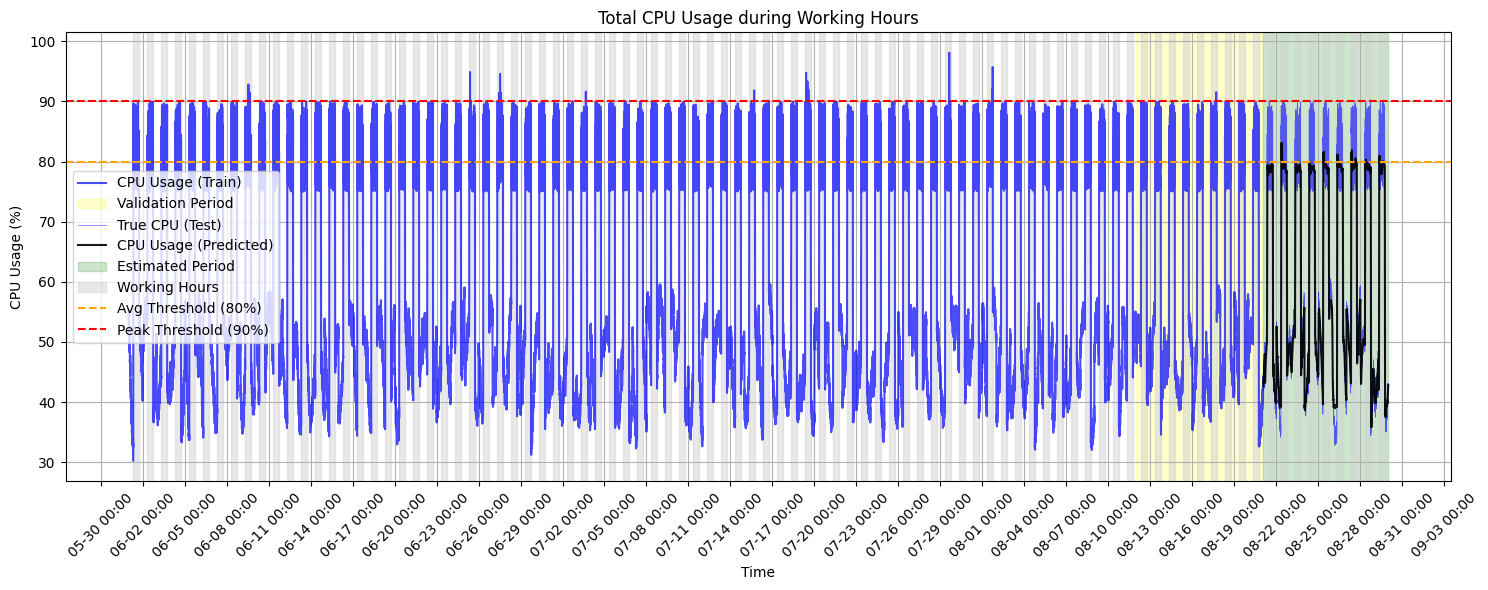

In [99]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['cpu'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "cpu_pred"

# 2. 업무시간 (08:00~18:00)만 추출
work_time = all_pred_series.between_time("08:00", "18:00")

# 3. 조건 1: 업무시간 평균 CPU 사용률 ≥ 80%
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 업무시간 중 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['cpu'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="CPU Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# 업그레이드 신호 표시
if len(upgrade_times) > 0:
    ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total CPU Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
# 평균 사용률 저장

cpu_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
cpu_avg_df.to_csv("cpu_avg_usage_CNN3.csv", index=False)

import json
with open("cpu_accuracy_metrics_CNN3.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_CNN3.csv") # 전체 cpu
test_series_pred.to_csv("cpu_usage_predicted_only_CNN3.csv") # 예측 구간 cpu
work_time.to_csv("cpu_usage_working_hours_CNN3.csv") # 업무시간 cpu
daily_peak.to_csv("cpu_peak_flag_per_day_CNN3.csv") # peak 발생 여부

with open("upgrade_decision_CNN3.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("cpu_plot_CNN3.png")

In [ ]:
!pip install streamlit

## 3. CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

In [100]:
from tensorflow.keras.layers import Bidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# reshape y to match CNN-BiLSTM output
y_train_re = y_train.reshape(-1, future_steps)
y_test_re  = y_test.reshape(-1, future_steps)

# ✅ CNN-BiLSTM 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, activation='tanh')),
    Dense(future_steps)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ✅ reshape for Conv1D & LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ✅ 학습
model.fit(X_train_cnn, y_train_re, epochs=20, batch_size=16, verbose=1)

# ✅ 예측
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test_re.reshape(-1, future_steps)

# ✅ 복원 (정규화 → 원래 단위 [%]로)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

# ✅ 성능 출력
print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,949 (261.52 KB)

 Trainable params: 66,949 (261.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0183
Epoch 2/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0092
Epoch 3/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0087
Epoch 4/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0089
Epoch 5/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0089
Epoch 6/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0087
Epoch 7/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0086
Epoch 8/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0084
Epoch 9/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0082
Epoch 10/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0083
Epoch 11/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0088
Epoch 12/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0087
Epoch 13/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0086
Epoch 14/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0086
Epoch 15/20
1

CNN-BiLSTM
MAE : 3.281706282504179
RMSE: 6.140759071057118
R2: 0.8883175667634784


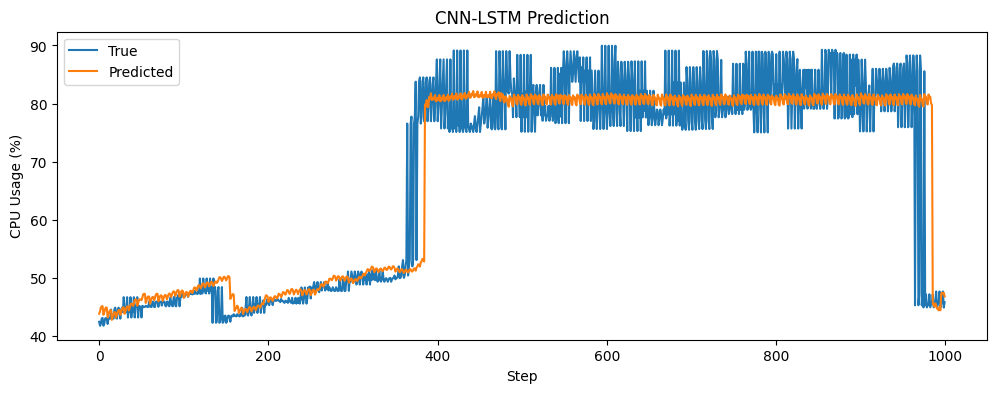

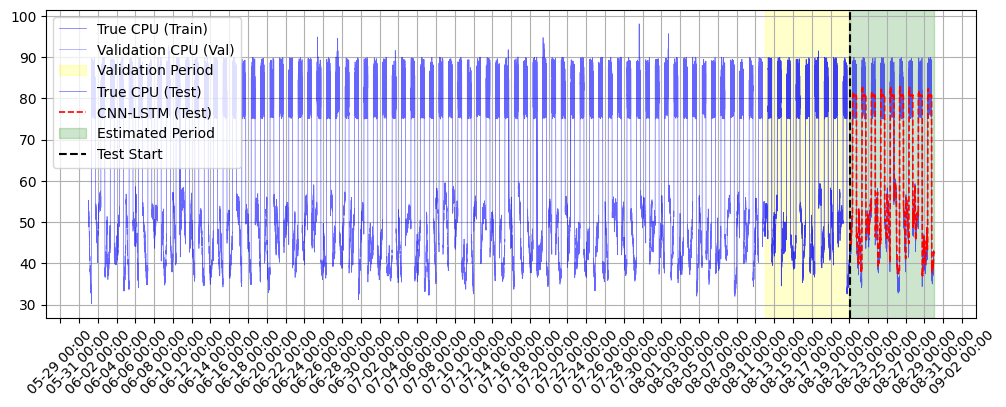

In [101]:
# plot

print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)

test_start_idx = val_end + past_steps
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
val_series = df['cpu'][train_end:val_end] # validation data
test_series_true= df['cpu'][test_start_idx:]

all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)

# validation
plt.plot(val_series, label="Validation CPU (Val)", color="blue", alpha = 0.4, linewidth = 0.5)
# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# test
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

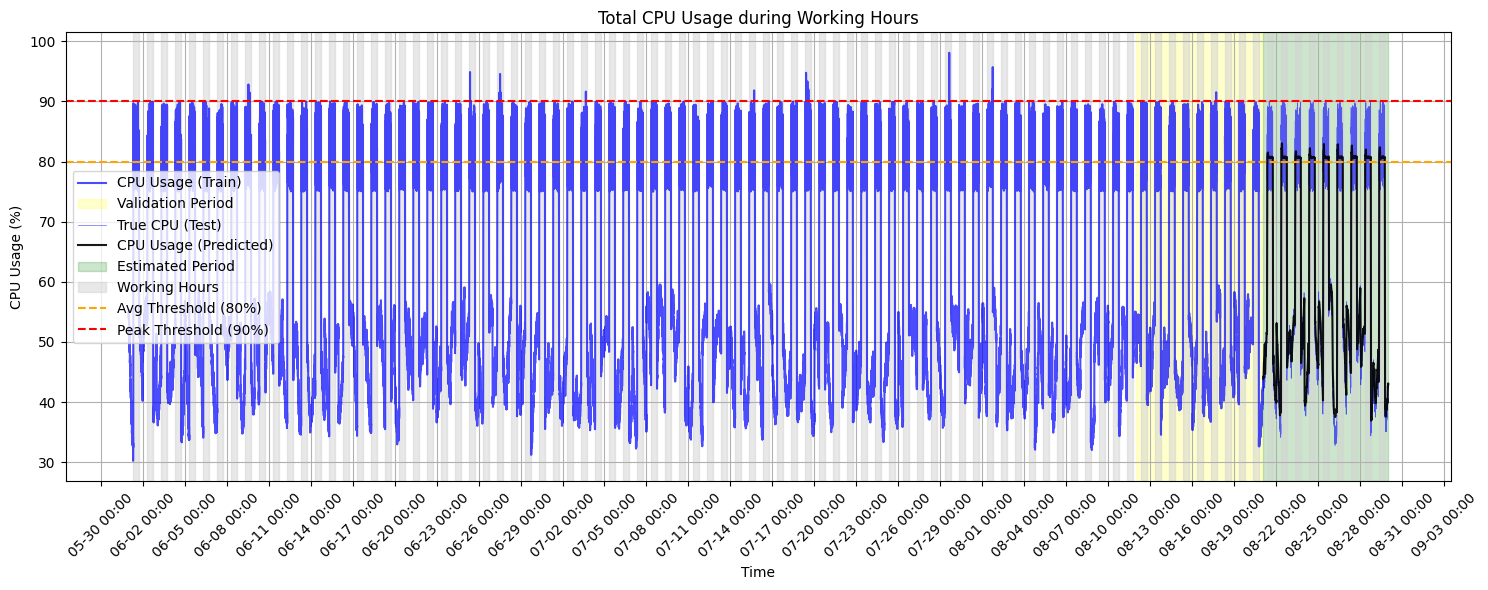

In [103]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['cpu'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "cpu_pred"

# 2. 업무시간 (08:00~18:00)만 추출
work_time = all_pred_series.between_time("08:00", "18:00")

# 3. 조건 1: 업무시간 평균 CPU 사용률 ≥ 80%
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 업무시간 중 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['cpu'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="CPU Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# 업그레이드 신호 표시
# if len(upgrade_times) > 0:
#     ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total CPU Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
cpu_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
cpu_avg_df.to_csv("cpu_avg_usage_Bi-LSTM3.csv", index=False)

import json
with open("cpu_accuracy_metrics_Bi-LSTM3.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_Bi-LSTM3.csv") # 전체 cpu
test_series_pred.to_csv("cpu_usage_predicted_only_Bi-LSTM3.csv") # 예측 구간 cpu
work_time.to_csv("cpu_usage_working_hours_Bi-LSTM3.csv") # 업무시간 cpu
daily_peak.to_csv("cpu_peak_flag_per_day_Bi-LSTM3.csv") # peak 발생 여부

with open("upgrade_decision_Bi-LSTM3.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("cpu_plot_Bi-LSTM3.png")

## streamlit 실행 파일(app.py)

In [69]:
pip install --upgrade streamlit

In [108]:
import os
# 1. 디렉토리 생성
os.makedirs("cpu_dashboard", exist_ok=True)

# 2. app.py 코드 문자열
code = '''import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

# CSS 스타일 삽입
st.markdown("""
    <style>
    /* 사이드바 배경 색 */
    [data-testid="stSidebar"] {
        background-color: #f5f5f5;
    }

    /* 라디오 그룹 제목 */
    [data-testid="stSidebar"] [data-testid="stRadio"] > label {
        font-size: 40px !important;
        font-weight: 600;
        color: #1a237e;
    }

    /* 라디오 버튼 항목들 */
    [data-testid="stSidebar"] [data-testid="stRadio"] label {
        font-size: 18px !important;
        color: #0d47a1 !important;
    }
    </style>
""", unsafe_allow_html=True)

# 분석 리소스 선택 (사이드바)
selected_resource = st.sidebar.radio("분석 대상 선택", ["CPU", "Memory", "Disk"])

# CPU
def show_cpu_analysis():
    st.markdown("<h1 style='font-size:30px;'>📈 CPU 사용량 및 증설 판단</h1>", unsafe_allow_html=True)

    # 이상적인 데이터

    st.markdown("#### 1. 이상적인 데이터")

    with st.expander("학습모델 : CNN-LSTM"):
        st.markdown("#### 학습모델 : CNN-LSTM ")

        # 데이터 불러오기
        df_all_ideal = pd.read_csv("cpu/all_series_CNN-LSTM.csv", index_col=0, parse_dates=True)
        df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN-LSTM.csv", index_col=0, parse_dates=True)
        df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN-LSTM.csv", index_col=0, parse_dates=True)
        df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN-LSTM.csv", index_col=0, parse_dates=True)

        avg_threshold = 80
        peak_threshold = 90

        # 정확도
        with open("cpu/cpu_accuracy_metrics_CNN-LSTM.json", "r") as f:
            metrics_ideal = json.load(f)

        # 결과 표시
        df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN-LSTM.csv")

        avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
        avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

        # 조건 재계산
        avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        st.markdown("#### ⚙️ 평균 CPU 사용률")
        st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
        st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
        focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
        focus_value = max(avg_work, avg_nowork)
        st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

        st.markdown("#### 📊 예측 정확도")
        st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
        st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
        st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

        st.markdown("#### 🔍 증설 판단")
        st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
        st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

        result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
        st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)
        expected_time_cond1 = None
        expected_time_cond2 = None


        # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
        if condition1_ideal:
            df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
            focus_column = 'avg'
            above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
            if not above_80.empty:
              expected_time_cond1 = above_80.index[0]

        # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
        if condition2_ideal:
            df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
            df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
            over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
            if not over_80_date.empty:
                expected_time_cond2 = over_80_date.index[0]

        # # 권유 시점 표시
        # if upgrade_ideal:
        #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond1:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond2:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)

        st.image("cpu/cpu_plot_CNN-LSTM.png") # fig 파일

    # CNN
    with st.expander("학습모델 : CNN"):
        st.markdown("#### 학습모델 : CNN ")

        # 데이터 불러오기
        df_all_ideal = pd.read_csv("cpu/all_series_CNN.csv", index_col=0, parse_dates=True)
        df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN.csv", index_col=0, parse_dates=True)
        df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN.csv", index_col=0, parse_dates=True)
        df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN.csv", index_col=0, parse_dates=True)

        avg_threshold = 80
        peak_threshold = 90

        # 정확도
        with open("cpu/cpu_accuracy_metrics_CNN.json", "r") as f:
            metrics_ideal = json.load(f)

        # 결과 표시
        df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN.csv")
        avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
        avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

        # 조건 재계산
        avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        st.markdown("#### ⚙️ 평균 CPU 사용률")
        st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
        st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
        focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
        focus_value = max(avg_work, avg_nowork)
        st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

        st.markdown("#### 📊 예측 정확도")
        st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
        st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
        st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

        st.markdown("#### 🔍 증설 판단")
        st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
        st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

        result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
        st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

        # 증설 필요시 시점 권유
        expected_time_cond1 = None
        expected_time_cond2 = None

        # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
        if condition1_ideal:
            df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
            focus_column = 'avg'
            above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
            if not above_80.empty:
              expected_time_cond1 = above_80.index[0]

        # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
        if condition2_ideal:
            df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
            df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
            over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
            if not over_80_date.empty:
                expected_time_cond2 = over_80_date.index[0]

        # # 권유 시점 표시
        # if upgrade_ideal:
        #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond1:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond2:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)
        st.image("cpu/cpu_plot_CNN.png") # fig 파일

    ## Bi-LSTM
    with st.expander("학습모델 : Bi-LSTM"):
        st.markdown("#### 학습모델 : Bi-LSTM ")

        # 데이터 불러오기
        df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM.csv", index_col=0, parse_dates=True)
        df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM.csv", index_col=0, parse_dates=True)
        df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM.csv", index_col=0, parse_dates=True)
        df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_Bi-LSTM.csv", index_col=0, parse_dates=True)

        avg_threshold = 80
        peak_threshold = 90

        # 조건 재계산
        avg_cpu_ideal = df_work_ideal.values.mean()
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        # 정확도
        with open("cpu/cpu_accuracy_metrics_Bi-LSTM.json", "r") as f:
            metrics_ideal = json.load(f)

        # 결과 표시
        df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM.csv")
        avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
        avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

        # 조건 재계산
        avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        st.markdown("#### ⚙️ 평균 CPU 사용률")
        st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
        st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
        focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
        focus_value = max(avg_work, avg_nowork)
        st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

        st.markdown("#### 📊 예측 정확도")
        st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
        st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
        st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

        st.markdown("#### 🔍 증설 판단")
        st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
        st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

        result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
        st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

        # 증설 필요시 시점 권유
        expected_time_cond1 = None
        expected_time_cond2 = None

        # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
        if condition1_ideal:
            df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
            focus_column = 'avg'
            above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
            if not above_80.empty:
              expected_time_cond1 = above_80.index[0]

        # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
        if condition2_ideal:
            df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
            df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
            over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
            if not over_80_date.empty:
                expected_time_cond2 = over_80_date.index[0]

        # # 권유 시점 표시
        # if upgrade_ideal:
        #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond1:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond2:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)


        st.image("cpu/cpu_plot_Bi-LSTM.png") # fig 파일


    # 2. 노이즈 많은 데이터

    # --- 파일 불러오기 ---
    df_all = pd.read_csv("cpu/all_series_CNN-LSTM2.csv", index_col=0, parse_dates=True)
    df_pred = pd.read_csv("cpu/cpu_usage_predicted_only_CNN-LSTM2.csv", index_col=0, parse_dates=True)
    df_work = pd.read_csv("cpu/cpu_usage_working_hours_CNN-LSTM2.csv", index_col=0, parse_dates=True)
    df_peak = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN-LSTM2.csv", index_col=0, parse_dates=True)


    # --- 조건 재계산 ---
    avg_threshold = 80
    peak_threshold = 90

    avg_cpu = df_work.values.mean()
    condition1_flag = avg_cpu >= avg_threshold

    peak_days = df_peak.values.sum()
    total_days = len(df_peak)
    condition2_flag = (peak_days / total_days) >= 0.8

    upgrade_flag = condition1_flag or condition2_flag

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    # 정확도 불러오기
    with open("cpu/cpu_accuracy_metrics_CNN-LSTM2.json", "r") as f:
        metrics = json.load(f)

    # --- 업그레이드 표시 시간 추출 ---
    if condition1_flag:
        upgrade_times = df_work.index
    elif condition2_flag:
        peak_day_list = df_peak[df_peak.values.flatten()].index[:5]
        upgrade_times = df_work[df_work.index.date.astype(str).isin(peak_day_list.astype(str))].index
    else:
        upgrade_times = []

    # --- Streamlit 출력 ---

    st.markdown("#### 2. 노이즈 많은 데이터")
    with st.expander("학습모델 : CNN-LSTM"):
      st.markdown("#### 학습모델 : CNN-LSTM")

      # 표시
      df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN-LSTM2.csv")
      avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
      avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

      # 조건 재계산
      avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
      condition1_ideal = avg_cpu_ideal >= avg_threshold

      peak_days_ideal = df_peak_ideal.values.sum()
      total_days_ideal = len(df_peak_ideal)
      condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

      upgrade_ideal = condition1_ideal or condition2_ideal

      st.markdown("#### ⚙️ 평균 CPU 사용률")
      st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
      st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
      focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
      focus_value = max(avg_work, avg_nowork)
      st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

      st.markdown("#### 📊 예측 정확도")
      st.markdown(f"- **MAE**: {metrics['MAE']}")
      st.markdown(f"- **RMSE**: {metrics['RMSE']}")
      st.markdown(f"- **R² Score**: {metrics['R2']}")

      st.markdown("#### 🔍 증설 판단")
      st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 CPU 사용량 ≥ 80%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
      st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

      # 결과 강조
      result_text = '🟥 <b>증설 필요</b>' if upgrade_flag else '🟩 <b>증설 불필요</b>'
      st.markdown(f"<h4>✅ 최종 판단: {result_text}</h3>", unsafe_allow_html=True)
      # 증설 필요시 시점 권유
      expected_time_cond1 = None
      expected_time_cond2 = None

        # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
      if condition1_ideal:
        df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
        focus_column = 'avg'
        above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
        if not above_80.empty:
                expected_time_cond1 = above_80.index[0]

        # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
        if condition2_ideal:
            df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
            df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
            over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
            if not over_80_date.empty:
                expected_time_cond2 = over_80_date.index[0]

        # # 권유 시점 표시
        # if upgrade_ideal:
        #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond1:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond2:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)


      st.image("cpu/cpu_plot_CNN-LSTM2.png") # fig 파일

    # CNN
    with st.expander("학습모델 : CNN"):
      st.markdown("#### 학습모델 : CNN")

      # --- 파일 불러오기 ---
      df_all = pd.read_csv("cpu/all_series_CNN2.csv", index_col=0, parse_dates=True)
      df_pred = pd.read_csv("cpu/cpu_usage_predicted_only_CNN2.csv", index_col=0, parse_dates=True)
      df_work = pd.read_csv("cpu/cpu_usage_working_hours_CNN2.csv", index_col=0, parse_dates=True)
      df_peak = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN2.csv", index_col=0, parse_dates=True)

      from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

      # 정확도 불러오기
      with open("cpu/cpu_accuracy_metrics_CNN2.json", "r") as f:
          metrics = json.load(f)

      # 표시
      df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN2.csv")
      avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
      avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

      # 조건 재계산
      avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
      condition1_ideal = avg_cpu_ideal >= avg_threshold

      peak_days_ideal = df_peak_ideal.values.sum()
      total_days_ideal = len(df_peak_ideal)
      condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

      upgrade_ideal = condition1_ideal or condition2_ideal

      st.markdown("#### ⚙️ 평균 CPU 사용률")
      st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
      st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
      focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
      focus_value = max(avg_work, avg_nowork)
      st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

      st.markdown("#### 📊 예측 정확도")
      st.markdown(f"- **MAE**: {metrics['MAE']}")
      st.markdown(f"- **RMSE**: {metrics['RMSE']}")
      st.markdown(f"- **R² Score**: {metrics['R2']}")

      st.markdown("#### 🔍 증설 판단")
      st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 CPU 사용량 ≥ 80%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
      st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

      # 결과 강조
      result_text = '🟥 <b>증설 필요</b>' if upgrade_flag else '🟩 <b>증설 불필요</b>'
      st.markdown(f"<h4>✅ 최종 판단: {result_text}</h3>", unsafe_allow_html=True)

      # 증설 필요시 시점 권유
      expected_time_cond1 = None
      expected_time_cond2 = None

      # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
      if condition1_ideal:
          df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
          focus_column = 'avg'
          above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
          if not above_80.empty:
              expected_time_cond1 = above_80.index[0]

      # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
      if condition2_ideal:
          df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
          df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
          over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
          if not over_80_date.empty:
              expected_time_cond2 = over_80_date.index[0]

      # 권유 시점 표시
      # if upgrade_ideal:
      #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
      #     if expected_time_cond1:
      #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
      #     if expected_time_cond2:
      #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)

      st.image("cpu/cpu_plot_CNN2.png") # fig 파일


    # Bi-LSTM
    with st.expander("학습모델 : Bi-LSTM"):
        st.markdown("#### 학습모델 : Bi-LSTM ")

        # 데이터 불러오기
        df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM2.csv", index_col=0, parse_dates=True)
        df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM2.csv", index_col=0, parse_dates=True)
        df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM2.csv", index_col=0, parse_dates=True)
        df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_Bi-LSTM2.csv", index_col=0, parse_dates=True)

        avg_threshold = 80
        peak_threshold = 90

        # 조건 재계산
        avg_cpu_ideal = df_work_ideal.values.mean()
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        # 정확도
        with open("cpu/cpu_accuracy_metrics_Bi-LSTM2.json", "r") as f:
            metrics_ideal = json.load(f)

        # 결과 표시
        df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM2.csv")
        avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
        avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

        # 조건 재계산
        avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        st.markdown("#### ⚙️ 평균 CPU 사용률")
        st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
        st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
        focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
        focus_value = max(avg_work, avg_nowork)
        st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

        st.markdown("#### 📊 예측 정확도")
        st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
        st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
        st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

        st.markdown("#### 🔍 증설 판단")
        st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
        st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

        result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
        st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

        # 증설 필요시 시점 권유
        expected_time_cond1 = None
        expected_time_cond2 = None

        # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
        if condition1_ideal:
            df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
            focus_column = 'avg'
            above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
            if not above_80.empty:
                expected_time_cond1 = above_80.index[0]

        # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
        if condition2_ideal:
            df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
            df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
            over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
            if not over_80_date.empty:
                expected_time_cond2 = over_80_date.index[0]

        # 권유 시점 표시
        # if upgrade_ideal:
        #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond1:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond2:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)


        st.image("cpu/cpu_plot_Bi-LSTM2.png") # fig 파일

   # 3. 증설 필요한 데이터

    st.markdown("#### 3. 증설 필요한 데이터")

    with st.expander("학습모델 : CNN-LSTM"):
        st.markdown("#### 학습모델 : CNN-LSTM ")

        # 데이터 불러오기
        df_all_ideal = pd.read_csv("cpu/all_series_CNN-LSTM3.csv", index_col=0, parse_dates=True)
        df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN-LSTM3.csv", index_col=0, parse_dates=True)
        df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN-LSTM3.csv", index_col=0, parse_dates=True)
        df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN-LSTM3.csv", index_col=0, parse_dates=True)

        avg_threshold = 80
        peak_threshold = 90

        # 정확도
        with open("cpu/cpu_accuracy_metrics_CNN-LSTM3.json", "r") as f:
            metrics_ideal = json.load(f)

        # 결과 표시
        df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN-LSTM3.csv")

        avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
        avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

        # 조건 재계산
        avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        st.markdown("#### ⚙️ 평균 CPU 사용률")
        st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
        st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
        focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
        focus_value = max(avg_work, avg_nowork)
        st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

        st.markdown("#### 📊 예측 정확도")
        st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
        st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
        st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

        st.markdown("#### 🔍 증설 판단")
        st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
        st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

        result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
        st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)
        # 증설 필요시 시점 권유
        expected_time_cond1 = None
        expected_time_cond2 = None

        # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
        if condition1_ideal:
            df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
            focus_column = 'avg'
            above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
            if not above_80.empty:
                expected_time_cond1 = above_80.index[0]

        # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
        if condition2_ideal:
            df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
            df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
            over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
            if not over_80_date.empty:
                expected_time_cond2 = over_80_date.index[0]

        # 권유 시점 표시
        # if upgrade_ideal:
        #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond1:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond2:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)

        st.image("cpu/cpu_plot_CNN-LSTM3.png") # fig 파일

    # CNN
    with st.expander("학습모델 : CNN"):
        st.markdown("#### 학습모델 : CNN ")

        # 데이터 불러오기
        df_all_ideal = pd.read_csv("cpu/ll_series_CNN3.csv", index_col=0, parse_dates=True)
        df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN3.csv", index_col=0, parse_dates=True)
        df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN3.csv", index_col=0, parse_dates=True)
        df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN3.csv", index_col=0, parse_dates=True)

        avg_threshold = 80
        peak_threshold = 90

        # 정확도
        with open("cpu/cpu_accuracy_metrics_CNN3.json", "r") as f:
            metrics_ideal = json.load(f)

        # 결과 표시
        df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN3.csv")
        avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
        avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

        # 조건 재계산
        avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        st.markdown("#### ⚙️ 평균 CPU 사용률")
        st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
        st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
        focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
        focus_value = max(avg_work, avg_nowork)
        st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

        st.markdown("#### 📊 예측 정확도")
        st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
        st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
        st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

        st.markdown("#### 🔍 증설 판단")
        st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
        st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

        result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
        st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)
        # 증설 필요시 시점 권유
        expected_time_cond1 = None
        expected_time_cond2 = None

        # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
        if condition1_ideal:
            df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
            focus_column = 'avg'
            above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
            if not above_80.empty:
                expected_time_cond1 = above_80.index[0]

        # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
        if condition2_ideal:
            df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
            df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
            over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
            if not over_80_date.empty:
                expected_time_cond2 = over_80_date.index[0]

        # 권유 시점 표시
        # if upgrade_ideal:
        #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond1:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond2:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)

        st.image("cpu/cpu_plot_CNN3.png") # fig 파일

    ## Bi-LSTM
    with st.expander("학습모델 : Bi-LSTM"):
        st.markdown("#### 학습모델 : Bi-LSTM ")

        # 데이터 불러오기
        df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM3.csv", index_col=0, parse_dates=True)
        df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM3.csv", index_col=0, parse_dates=True)
        df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM3.csv", index_col=0, parse_dates=True)
        df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_Bi-LSTM3.csv", index_col=0, parse_dates=True)

        avg_threshold = 80
        peak_threshold = 90

        # 조건 재계산
        avg_cpu_ideal = df_work_ideal.values.mean()
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        # 정확도
        with open("cpu/cpu_accuracy_metrics_Bi-LSTM3.json", "r") as f:
            metrics_ideal = json.load(f)

        # 결과 표시
        df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM3.csv")
        avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
        avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

        # 조건 재계산
        avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
        condition1_ideal = avg_cpu_ideal >= avg_threshold

        peak_days_ideal = df_peak_ideal.values.sum()
        total_days_ideal = len(df_peak_ideal)
        condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

        upgrade_ideal = condition1_ideal or condition2_ideal

        st.markdown("#### ⚙️ 평균 CPU 사용률")
        st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
        st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
        focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
        focus_value = max(avg_work, avg_nowork)
        st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

        st.markdown("#### 📊 예측 정확도")
        st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
        st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
        st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

        st.markdown("#### 🔍 증설 판단")
        st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
        st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

        result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
        st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

        # 증설 필요시 시점 권유
        expected_time_cond1 = None
        expected_time_cond2 = None

        # 조건 1 충족 시: 평균 사용률이 처음 80% 넘는 시점 찾기
        if condition1_ideal:
            df_work_ideal['avg'] = df_work_ideal.mean(axis=1)
            focus_column = 'avg'
            above_80 = df_work_ideal[df_work_ideal[focus_column] >= avg_threshold]
            if not above_80.empty:
                expected_time_cond1 = above_80.index[0]

        # 조건 2 충족 시: 누적 피크 발생 비율이 80% 넘은 시점 찾기
        if condition2_ideal:
            df_peak_ideal['cumsum'] = df_peak_ideal.iloc[:, 0].cumsum()
            df_peak_ideal['ratio'] = df_peak_ideal['cumsum'] / total_days_ideal
            over_80_date = df_peak_ideal[df_peak_ideal['ratio'] >= 0.8]
            if not over_80_date.empty:
                expected_time_cond2 = over_80_date.index[0]

        # 권유 시점 표시
        # if upgrade_ideal:
        #     st.markdown("<p style='font-size:16px;'>⏱️ <b>증설 권유 시점:</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond1:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 1 기준: <b>{expected_time_cond1.strftime('%Y-%m-%d %H:%M')}</b></p>", unsafe_allow_html=True)
        #     if expected_time_cond2:
        #         st.markdown(f"<p style='font-size:15px;'>✔️ 조건 2 기준: <b>{expected_time_cond2.strftime('%Y-%m-%d')}</b></p>", unsafe_allow_html=True)

        st.image("cpu/cpu_plot_Bi-LSTM3.png") # fig 파일


   # pdf 생성
    from fpdf import FPDF

    st.markdown("---")
    st.markdown("### 📝 PDF 보고서 만들기")

    # --- 체크박스 선택
    include_accuracy = st.checkbox("예측 정확도 포함", value=True)
    include_conditions = st.checkbox("증설 조건 판단 포함", value=True)
    include_chart = st.checkbox("CPU 사용량 그래프 포함", value=True)

    if st.button("📄 PDF로 저장하기"):
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)

        pdf.set_title("CPU Usage Report")

        pdf.cell(200, 10, txt="📈 CPU 사용량 및 증설 판단 보고서", ln=True, align="L")

        if include_accuracy:
            pdf.ln(10)
            pdf.set_font("Arial", style='B', size=12)
            pdf.cell(200, 10, txt="예측 정확도", ln=True)
            pdf.set_font("Arial", size=11)
            pdf.cell(200, 8, txt=f"- MAE: {metrics['MAE']}", ln=True)
            pdf.cell(200, 8, txt=f"- RMSE: {metrics['RMSE']}", ln=True)
            pdf.cell(200, 8, txt=f"- R² Score: {metrics['R2']}", ln=True)

        if include_conditions:
            pdf.ln(10)
            pdf.set_font("Arial", style='B', size=12)
            pdf.cell(200, 10, txt="증설 조건 판단", ln=True)
            pdf.set_font("Arial", size=11)
            pdf.cell(200, 8, txt=f"조건 1: {condition1_flag} ({avg_cpu:.2f}%)", ln=True)
            pdf.cell(200, 8, txt=f"조건 2: {condition2_flag} ({int(peak_days)}/{total_days})", ln=True)
            decision = "증설 필요" if upgrade_flag else "증설 불필요"
            pdf.cell(200, 8, txt=f"최종 판단: {decision}", ln=True)

        if include_chart:
            # 그래프를 이미지로 저장
            chart_path = "cpu_dashboard"
            fig.savefig(chart_path, bbox_inches='tight')
            pdf.ln(10)
            pdf.set_font("Arial", style='B', size=12)
            pdf.cell(200, 10, txt="CPU 사용량 그래프", ln=True)
            pdf.image(chart_path, x=10, w=190)

        output_path = r"C:\jupyter\cpu_dashboard\cpu_report.pdf"
        pdf.output(output_path)

        st.success(f"PDF 보고서가 저장되었습니다: `{output_path}`")
        st.download_button("📥 PDF 다운로드", data=open(output_path, "rb"), file_name="cpu_report.pdf")
def show_memory_analysis():
    st.markdown("🛠 Memory 분석은 준비 중입니다.")

def show_disk_analysis():
    st.markdown("🛠 Disk 분석은 준비 중입니다.")

# 선택한 리소스에 따라 분석 함수 호출
if selected_resource == "CPU":
    show_cpu_analysis()
elif selected_resource == "Memory":
    show_memory_analysis()
elif selected_resource == "Disk":
    show_disk_analysis()


# st.markdown("<h1 style='font-size:30px;'>📈 CPU 사용량 및 증설 판단</h1>", unsafe_allow_html=True)




'''

# 파일 저장
with open("cpu_dashboard/app.py", "w", encoding="utf-8") as f:
    f.write(code)


# 저장후에 bash에서 streamlit run app.py 입력